# HSMA 6 - Session 4G - Exercise 1 - Explainable AI Techniques

In this notebook, we'll be exploring how to use a couple of different explainable AI techniques.

We'll be using a different dataset to take a look into this today. The penguins dataset is a great dataset for practising classification problems. This data has been pulled using the excellent `palmerpenguins` package. 

[LINK](https://allisonhorst.github.io/palmerpenguins/)

What we need to know is that 

- The dataset is made up of 344 rows/ instances
- Each row has columns pertaining to sex, species, island on which they are found, bill length, bill depth, flipper length, and body mass.
- There are three species (classes) to consider: Adelie, Chinstrap and Gentoo.
    - These are the **targets**.

In this exercise you will need go through the code and fill in any missing spaces. 

By the end of this exercise you should know 
- how to calculate feature importance using the MDI method for tree-based models
- how to calculate feature importance for any model using the permutation feature importance method
- how to create partial dependence plots (PDPs) and individual conditionla expectation (ICE) plots for any model 
- how to use the SHAP library to understand a model 

The SHAP code does vary subtly for different kinds of model; we will just be working with an XGboost model in this case to match what we've done in the lecture.

#### Library Imports

In [4]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

import shap

# Java Script for SHAP Plots
shap.initjs()

#### Load & Clean Data

Run this cell to load the dataframe.

In [5]:
penguins = pd.read_csv("../datasets/penguins.csv")

Examine the dataset with your choice(s) of function(s). 

In [6]:
penguins.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,island_Biscoe,island_Dream,island_Torgersen,male,target
0,32.1,15.5,188.0,3050.0,2009,0,1,0,0.0,0
1,33.1,16.1,178.0,2900.0,2008,0,1,0,0.0,0
2,33.5,19.0,190.0,3600.0,2008,0,0,1,0.0,0
3,34.0,17.1,185.0,3400.0,2008,0,1,0,0.0,0
4,34.1,18.1,193.0,3475.0,2007,0,0,1,NaN,0


Run the code below to convert the classes 0, 1 and 2 into the relevant species names and add this as a new column.  

Try to understand how this is working - it's a useful little pattern to know for your own datasets!

First, we are going to create a *dictionary*. Can you remember what we call the parts before and the parts after the colon in the dictionary?

In [7]:
# Define the different classes/ species
class_dict = {0 : 'Adelie',
             1 : 'Chinstrap',
             2 : 'Gentoo'}

class_dict

{0: 'Adelie', 1: 'Chinstrap', 2: 'Gentoo'}

Now we are going to use our dictionary for creating the column. 

How do you think this is working? You may want to look up the `get` method of the standard python dictionary, and the `apply` method of pandas, just to understand a little more about this very useful way of making new conditional columns.

In [8]:
# Add species into the dataframe
penguins['species'] = penguins['target'].apply(lambda x: class_dict.get(x))

# view a random sample of 10 rows
penguins.sample(10)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,island_Biscoe,island_Dream,island_Torgersen,male,target,species
65,38.1,18.6,190.0,3700.0,2008,0,1,0,0.0,0,Adelie
138,42.3,21.2,191.0,4150.0,2007,0,1,0,1.0,0,Adelie
119,41.1,17.6,182.0,3200.0,2007,0,0,1,0.0,0,Adelie
126,41.3,21.1,195.0,4400.0,2008,1,0,0,1.0,0,Adelie
171,46.5,17.9,192.0,3500.0,2007,0,1,0,0.0,1,Chinstrap
5,34.4,18.4,184.0,3325.0,2007,0,0,1,0.0,0,Adelie
0,32.1,15.5,188.0,3050.0,2009,0,1,0,0.0,0,Adelie
158,45.2,16.6,191.0,3250.0,2009,0,1,0,0.0,1,Chinstrap
217,54.2,20.8,201.0,4300.0,2008,0,1,0,1.0,1,Chinstrap
197,50.7,19.7,203.0,4050.0,2009,0,1,0,1.0,1,Chinstrap


Let's take a look at some stats about the data to get an idea of the scale and distribution of the different features. Run the cell below to do this. 

In [9]:
# Take a look at some stats about the data
penguins.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,island_Biscoe,island_Dream,island_Torgersen,male,target
count,342.000000,342.000000,342.000000,342.000000,344.000000,344.000000,344.000000,344.000000,333.000000,344.000000
mean,43.921930,17.151170,200.915205,4201.754386,2008.029070,0.488372,0.360465,0.151163,0.504505,0.918605
std,5.459584,1.974793,14.061714,801.954536,0.818356,0.500593,0.480835,0.358729,0.500732,0.893320
min,32.100000,13.100000,172.000000,2700.000000,2007.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.225000,15.600000,190.000000,3550.000000,2007.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,44.450000,17.300000,197.000000,4050.000000,2008.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,48.500000,18.700000,213.000000,4750.000000,2009.000000,1.000000,1.000000,0.000000,1.000000,2.000000
max,59.600000,21.500000,231.000000,6300.000000,2009.000000,1.000000,1.000000,1.000000,1.000000,2.000000


#### Plot the Data

Before we go any further, let's plot the iris dataset to see how the petal width and length relate to the species.

Fill in the gaps below to create the plot

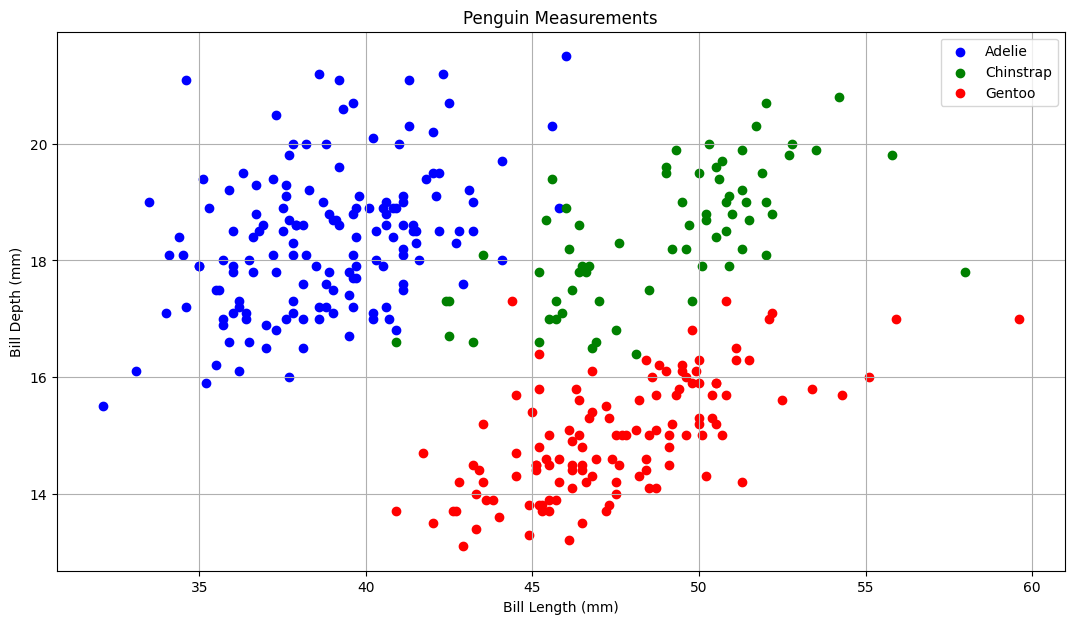

In [10]:
adelie = penguins[penguins.species=='Adelie']
chinstrap = penguins[penguins.species=='Chinstrap']
gentoo = penguins[penguins.species=='Gentoo']

fig, ax = plt.subplots()
fig.set_size_inches(13, 7) # adjusting the length and width of plot

# lables and scatter points
ax.scatter(
    adelie['bill_length_mm'],
    adelie['bill_depth_mm'],
    label="Adelie",
    facecolor="blue"
    )
ax.scatter(
    chinstrap['bill_length_mm'],
    chinstrap['bill_depth_mm'],
    label="Chinstrap",
    facecolor="green"
    )
ax.scatter(
    gentoo['bill_length_mm'],
    gentoo['bill_depth_mm'],
    label="Gentoo",
    facecolor="red"
    )


ax.set_xlabel("Bill Length (mm)")
ax.set_ylabel("Bill Depth (mm)")
ax.grid()
ax.set_title("Penguin Measurements")
ax.legend()

Now it's your turn; create a copy of the plot above, but this time we are interested in flipper length and body mass.

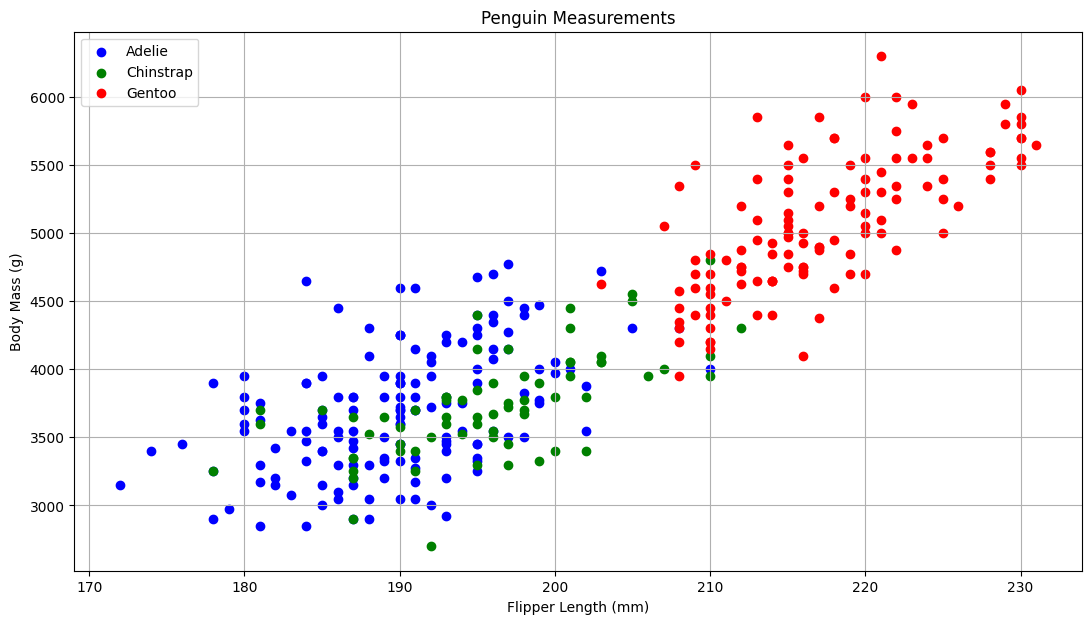

In [11]:
adelie = penguins[penguins.species=='Adelie']
chinstrap = penguins[penguins.species=='Chinstrap']
gentoo = penguins[penguins.species=='Gentoo']

fig, ax = plt.subplots()
fig.set_size_inches(13, 7) # adjusting the length and width of plot

# lables and scatter points
ax.scatter(
    adelie['flipper_length_mm'],
    adelie['body_mass_g'],
    label="Adelie",
    facecolor="blue"
    )
ax.scatter(
    chinstrap['flipper_length_mm'],
    chinstrap['body_mass_g'],
    label="Chinstrap",
    facecolor="green"
    )
ax.scatter(
    gentoo['flipper_length_mm'],
    gentoo['body_mass_g'],
    label="Gentoo",
    facecolor="red"
    )


ax.set_xlabel("Flipper Length (mm)")
ax.set_ylabel("Body Mass (g)")
ax.grid()
ax.set_title("Penguin Measurements")
ax.legend()

#### Performing Classification

Time to get on to the machine learning aspect.

It's always important to spend some time understanding your dataset first, though! What we've done above is just the tip of the iceberg, but it's a good start.

Now we're going to process our dataset for machine learning as we did in the logistic regression, decision tree and boosted tree sessions - this time we're going to be using XGBoost.

In [12]:
# Define features (X) and target (y)
# Droping the target and species since we only need the measurements
X = penguins.drop(['target','species'], axis=1)
y = penguins['target']

# get class and features names
class_names = penguins.species.unique()
feature_names = X.columns

# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

# Instantiate an XGBoost model and fit it
model = XGBClassifier()

model.fit(X_train, y_train)

y_pred_train_xg = model.predict(X_train)
y_pred_test_xg = model.predict(X_test)




### Feature Importance

##### Look at feature importance using the feature_importances_ attribute

For our XGboost model, this attribute is the mean decrease in impurity for each feature.

In [13]:
importances = pd.DataFrame()
importances['importance'] = model.feature_importances_

#### Mean decrease in impurity

Generate a plot of the MDI feature importances.

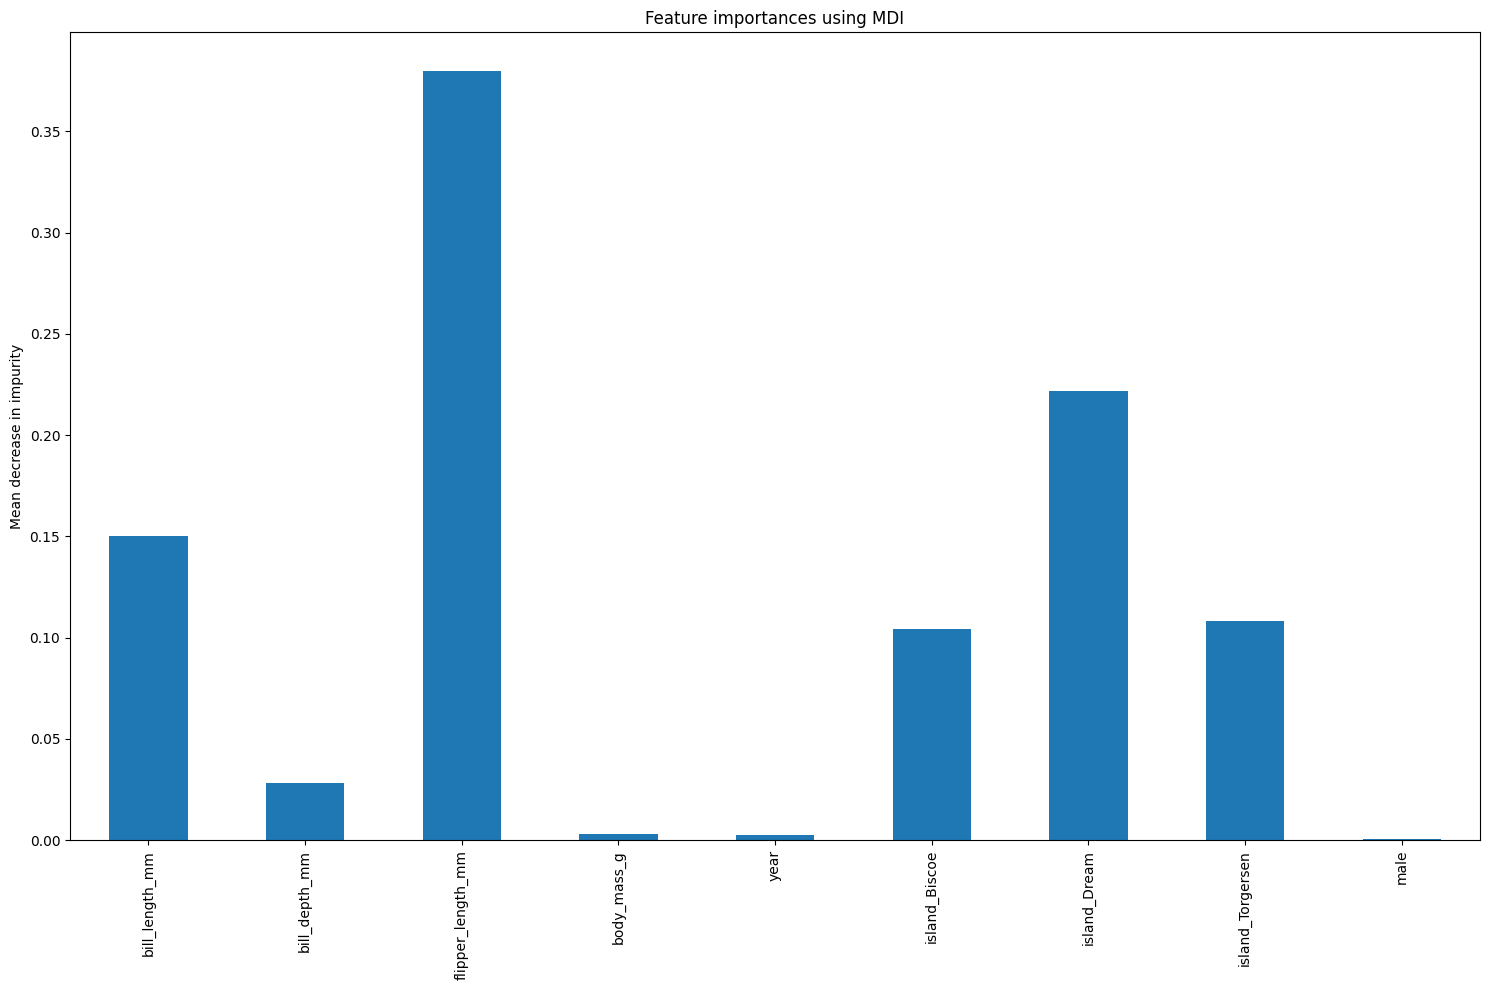

In [14]:
# Create a list of the feature names
feature_names = X.columns.to_list()

# Turn this into a series
model_importances_mdi_series = pd.Series(
    importances['importance'].values,
    index=feature_names
    )

# Run the code below to plot the output
fig, ax = plt.subplots(figsize=(15,10))

model_importances_mdi_series.plot.bar(ax=ax)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Permutation Feature Importance

Calculate permutation feature importance for this dataset and plot it.

Include error bars.

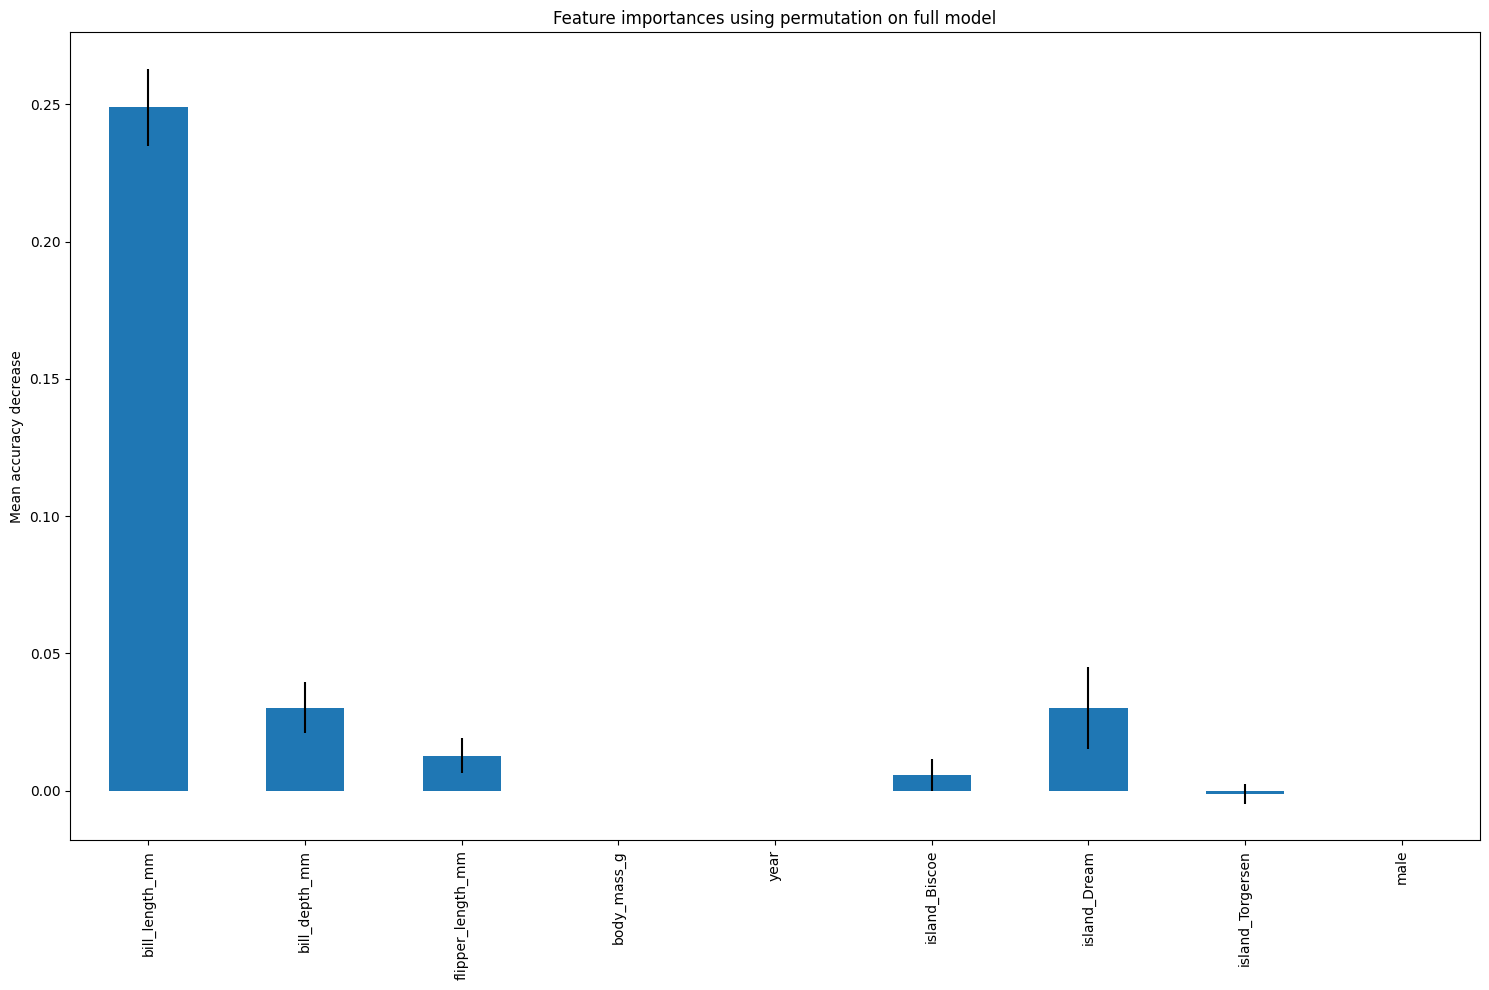

In [18]:
# Permutation feature importance
result = permutation_importance(
    estimator= model, 
    X=X_test,
    y=y_test,
    n_repeats=10,
    random_state=42
    )

model_importances_pfi_series = pd.Series(
    result.importances_mean, 
    index=feature_names)

std = std = result.importances_std


fig, ax = plt.subplots(figsize=(15,10))
model_importances_pfi_series.plot.bar(
    yerr=std, 
    ax=ax
)

ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

#### Predictions

Use the model to make predictions for the training and test set

In [19]:
# Training predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#### Assessing Performance

Run this code to generate metrics for the training and test performance of this model.

In [20]:
accuracy_train = np.mean(y_pred_train == y_train)
accuracy_test = np.mean(y_pred_test == y_test)

print (f'Accuracy of predicting training data = {accuracy_train:.2%}')
print (f'Accuracy of predicting test data = {accuracy_test:.2%}')

Accuracy of predicting training data = 100.00%
Accuracy of predicting test data = 96.51%


## PDP Plots

Now let's create a partial dependence plot for flipper length.

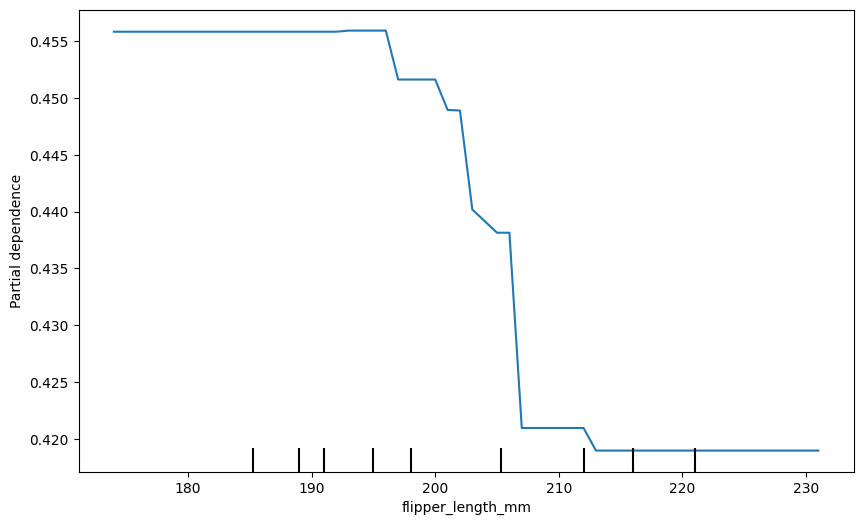

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X_train,  # The feature you want to plot
    features=['flipper_length_mm'],  # List of features to plot
    target=0,
    kind='average',
    ax=ax,
    random_state=42
)

plt.show()

Now create two plots side-by-side for bill length and bill depth.

HINT: You *don't* need to create multiple separate plots using matplotlib for this - you can do it from within the graphing function we're using from scikit-learn.

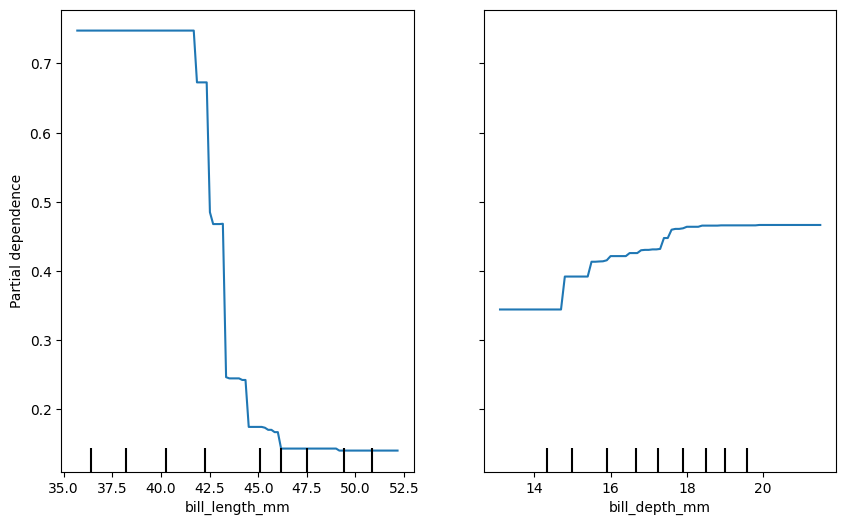

In [25]:

fig, ax = plt.subplots(figsize=(10, 6))

display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X_train,  # The feature you want to plot
    features=['bill_length_mm', 'bill_depth_mm'],  # List of features to plot
    target=0,
    kind='average',
    ax=ax,
    random_state=42
)

plt.show()

## ICE Plots

Now create three ICE plots of the same feature - one for each class.
Make sure to give each plot a name.

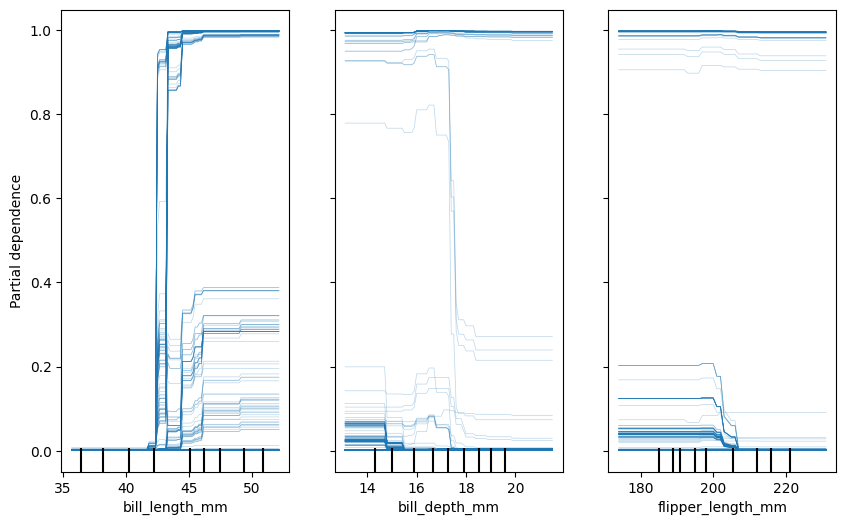

In [26]:
# fig, ax = plt.subplots(figsize=(10, 6))
# display = PartialDependenceDisplay.from_estimator(
#     estimator=## YOUR CODE HERE,  # Your fitted model
#     X=## YOUR CODE HERE,  # Your feature matrix
#     features=## YOUR CODE HERE,  # List of features to plot
#     target=0,
#     kind=## YOUR CODE HERE,  # Type of PDP
#     ax=## YOUR CODE HERE,
#     random_state=## YOUR CODE HERE
# )
# title_string = "Adelie Penguins - Bill Length ICE Plot"
# ## YOUR CODE HERE
# plt.show()


fig, ax = plt.subplots(figsize=(10, 6))

display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X_train,  # The feature you want to plot
    features=['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm'],  # List of features to plot
    target=1,
    kind='individual',
    ax=ax,
    random_state=42
)
title_string = "Adelie Penguins - Bill Length ICE Plot"
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    estimator=## YOUR CODE HERE,  # Your fitted model
    X=## YOUR CODE HERE,  # Your feature matrix
    features=## YOUR CODE HERE,  # List of features to plot
    target=1,
    kind=## YOUR CODE HERE,  # Type of PDP
    ax=## YOUR CODE HERE,
    random_state=## YOUR CODE HERE
)
title_string = "Chinstrap Penguins - Bill Length ICE Plot"
## YOUR CODE HERE
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    estimator=## YOUR CODE HERE,  # Your fitted model
    X=## YOUR CODE HERE,  # Your feature matrix
    features=## YOUR CODE HERE,  # List of features to plot
    target=2,
    kind=## YOUR CODE HERE,  # Type of PDP
    ax=## YOUR CODE HERE,
    random_state=## YOUR CODE HERE
)
title_string = "Gentoo Penguins - Bill Length ICE Plot"
## YOUR CODE HERE
plt.show()

Now, just for one of the classes, create an ICE plot for bill_length_mm that also shows the average of all the ICE plots - a joint PDP/ICE plot, effectively!

Again, make sure you provide a title.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    estimator=## YOUR CODE HERE,  # Your fitted model
    X=## YOUR CODE HERE,  # Your feature matrix
    features=## YOUR CODE HERE,  # List of features to plot
    target=## YOUR CODE HERE,
    kind=## YOUR CODE HERE,  # Type of PDP
    ax=## YOUR CODE HERE,
    random_state=## YOUR CODE HERE
)

# set the title based on the class you've chosen - can you remember what 0, 1 and 2 relate to?
plt.title(
    ## YOUR CODE HERE
)
plt.show()

## SHAP

We have a multiclass problem with our penguins dataset.

This results in some slightly different outputs from our SHAP code to what we covered in the main exercise, which can be confusing to deal with, so for now we're just going to focus on a binary classification problem - is a penguin an Adelie, or not?

Run the code below to turn this into a binary classification problem and retrain the model.

In [ ]:
penguins_binary = penguins.copy()

# If Adelie penguin, return 1, else return 0
penguins_binary['target'] = np.where(penguins_binary['target'] == 0, 1, 0)
penguins_binary['species'] = np.where(penguins_binary['species'] == "Adelie", "Adelie", "Not Adelie")

penguins_binary.sample(20)

In [ ]:
# Droping the target and species since we only need the measurements
X = penguins_binary.drop(['target','species'], axis=1)

# Define features (X) and target (y)
X = X
y = penguins_binary['target']

# get class and features names
class_names = penguins_binary.species.unique()
feature_names = X.columns

# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

# Instantiate an XGBoost model and fit it
model = XGBClassifier(random_state=42)

model.fit(X_train, y_train)

### Obtaining Shap Values

Generate a SHAP explainer for our model, using X_train as the background data.

In [ ]:
explainer = # YOUR CODE HERE

Now create the shap_values object, using X_test as the foreground data.

In [ ]:
shap_values = # YOUR CODE HERE
shap_values

It looks like it's returned our outputs just as an array instead of a SHAP explanation object. Run the code below to turn our object into a proper shap.Explanation() object, as this is what all the plotting functions will be expecting.

In [ ]:
# Create an Explanation object
shap_values = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test.values,
    feature_names=X.columns
    )

Now let's see what this looks like instead.

In [ ]:
shap_values

You're looking for the object `shap_values` to look like the above, with `.values`, `.base_values` and `.data` present. 

You can always use the code in the previous cell to convert any outputs that aren't quite right.

Finally, let's grab just the numeric component (our actual shap values).

Note that in this case `shap_values.values` isn't strictly necessary - we could have just pulled in the values that were returned from our explainer - but generally, the explainer returns the shap explanation object without this extra step being required, so `shap_values.values` is a more robust approach to use.

In [ ]:
shap_values_numeric = shap_values.values
shap_values_numeric

### Exploring the SHAP outputs

First, let's just get a list of our most important features according to SHAP. 

We're going to compare this to the MDI importances we calculated earlier.

In [ ]:
# get feature importance for comparison using MDI method
features = list(X_train)
feature_importances = model.feature_importances_
importances = pd.DataFrame(index=features)
importances['importance_mdi'] = feature_importances
importances['rank'] = importances['importance_mdi'].rank(ascending=False).values
importances.sort_values('rank').head()

importances

In [ ]:
# Get shapley importances
# Calculate mean Shapley value for each feature in trainign set
importances['mean_shapley_values'] = np.mean(
    ##YOUR CODE HERE,
    axis=##YOUR CODE HERE
    )

# Calculate mean absolute Shapley value for each feature in trainign set
# This will give us the average importance of each feature
importances['mean_abs_shapley_values'] = np.mean(
    ##YOUR CODE HERE,
    axis=##YOUR CODE HERE
    )

importance_top = \
    importances.sort_values(
        by='importance_mdi',
        ascending=False
        ).index

shapley_top = \
    importances.sort_values(
        by=##YOUR CODE HERE,
        ascending=##YOUR CODE HERE
        ).index

# Add to DataFrame
top_features = pd.DataFrame()
top_features['importances_mdi'] = importance_top.values
top_features['Shapley'] = ##YOUR CODE HERE

# Display
top_features

#### SHAP plots

Generate a bar plot of the SHAP values.

In [ ]:
##YOUR CODE HERE

Generate a beeswarm plot.

In [ ]:
##YOUR CODE HERE

Generate a waterfall plot for 5 different examples from the dataset.

In [ ]:
##YOUR CODE HERE

In [ ]:
##YOUR CODE HERE

In [ ]:
##YOUR CODE HERE

In [ ]:
##YOUR CODE HERE

In [ ]:
##YOUR CODE HERE

#### Dependence Plots for each Class (Species)

First, generate a scatter plot for the bill length.

In [ ]:
##YOUR CODE HERE

Now colour this by bill depth.

In [ ]:
##YOUR CODE HERE

Now colour it by the most strongly interacting feature.

In [ ]:
##YOUR CODE HERE

# Extension

Now let's iterate through and create scatter plots per column.

In [ ]:
# dependence plots
fig, ax = plt.subplots(
    nrows=##YOUR CODE HERE,
    ncols=##YOUR CODE HERE,
    figsize=(20,10)
    )
ax = ax.ravel()

for idx, col_name in enumerate(feature_names):
    shap.plots.scatter(
        ##YOUR CODE HERE,
        show=##YOUR CODE HERE,
        ax=##YOUR CODE HERE
        )

#### Force Plots

Create a force plot for the whole dataset.

In [ ]:
##YOUR CODE HERE

Create a force plot for five randomly chosen pieces of data.

In [ ]:
##YOUR CODE HERE

In [ ]:
##YOUR CODE HERE

In [ ]:
##YOUR CODE HERE

In [ ]:
##YOUR CODE HERE

In [ ]:
##YOUR CODE HERE